# 와인2

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

from sklearn.ensemble import RandomForestClassifier

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/와인/train.csv')
test = pd.read_csv('/content/drive/MyDrive/와인/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/와인/sample_submission.csv')

### 1) 데이터 전처리

In [ ]:
train['type'] = train['type'].map(lambda x : 0 if x == 'white' else 1)

In [ ]:
train = train.append(train[train['quality'].isin([4,7,8])])
train['quality'].value_counts().sort_index()

3      26
4     372
5    1788
6    2416
7    1848
8     304
9       5
Name: quality, dtype: int64

In [ ]:
import numpy as np

def ACC(true, pred):   
    score = np.mean(true==pred)
    return score

In [ ]:
def make_plot():

  acc = ACC(y_valid, y_pred)

  validation = pd.DataFrame({'y_valid':y_valid, 'y_pred':y_pred})

  validation_count = pd.DataFrame(validation['y_valid'].value_counts().sort_index())
  validation_count.loc[validation['y_pred'].value_counts().sort_index().index, 'y_pred'] = validation['y_pred'].value_counts().sort_index()
  validation_count = validation_count.fillna(0)

  x = validation_count.index
  y_valid_count = validation_count['y_valid']
  y_pred_count = validation_count['y_pred']

  width = 0.35

  plt.figure(dpi=150)

  plt.title('ACC : ' + str(acc)[:6])
  plt.xlabel('quality')
  plt.ylabel('count')

  p1 = plt.bar([idx-width/2 for idx in x], y_valid_count, width, label='real')
  p2 = plt.bar([idx+width/2 for idx in x], y_pred_count,  width, label='pred')

  plt.legend()
  plt.show()

In [ ]:
features = train.columns[2:]

In [ ]:
X = train[features]
y = train['quality']

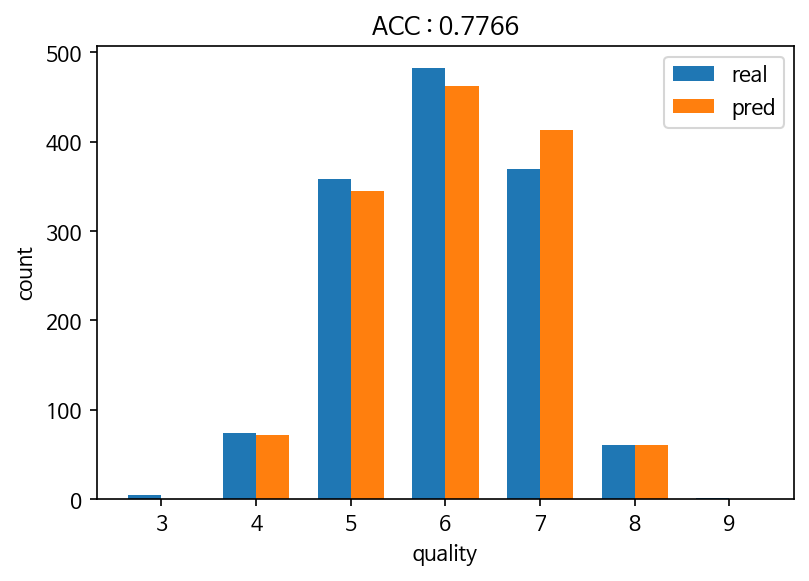

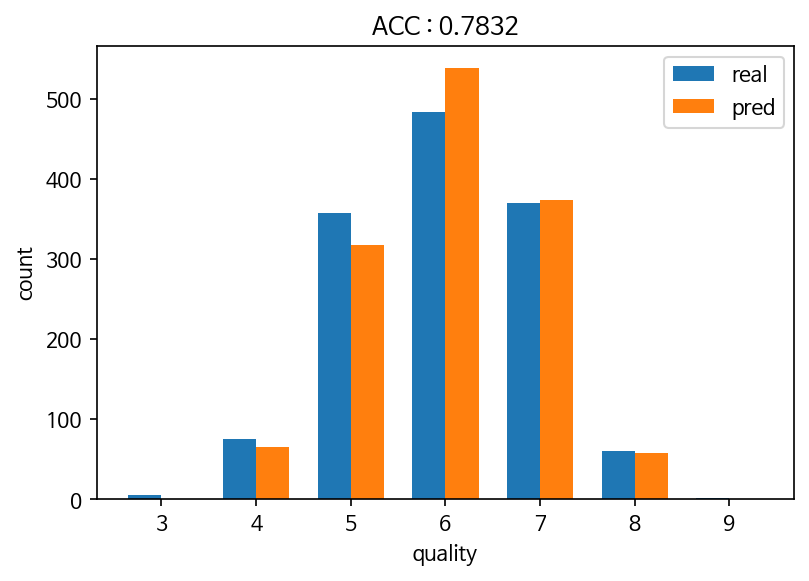

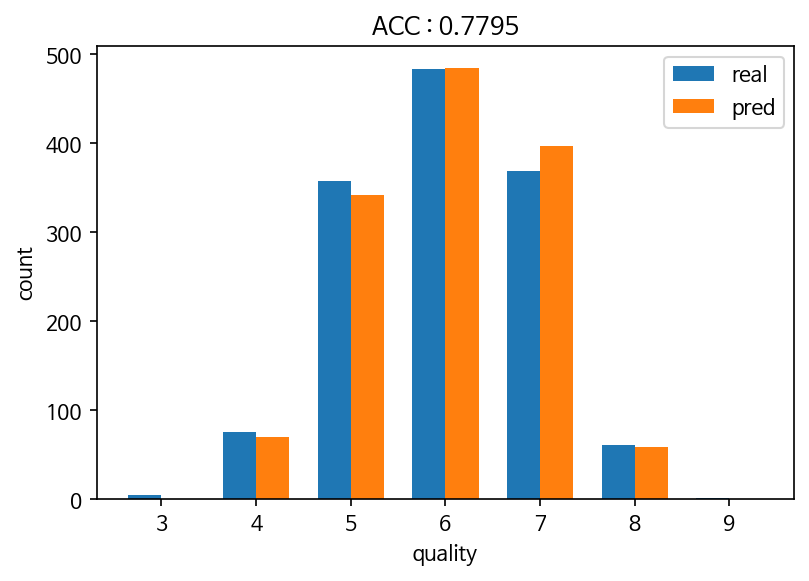

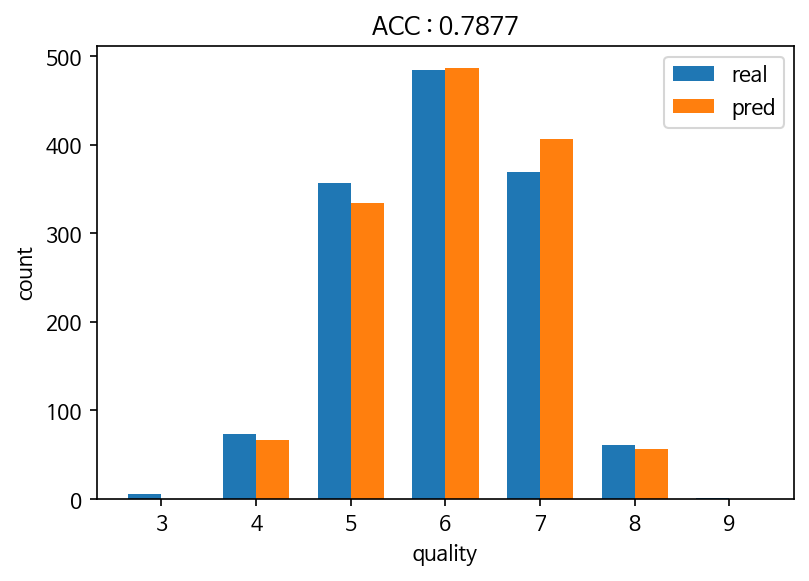

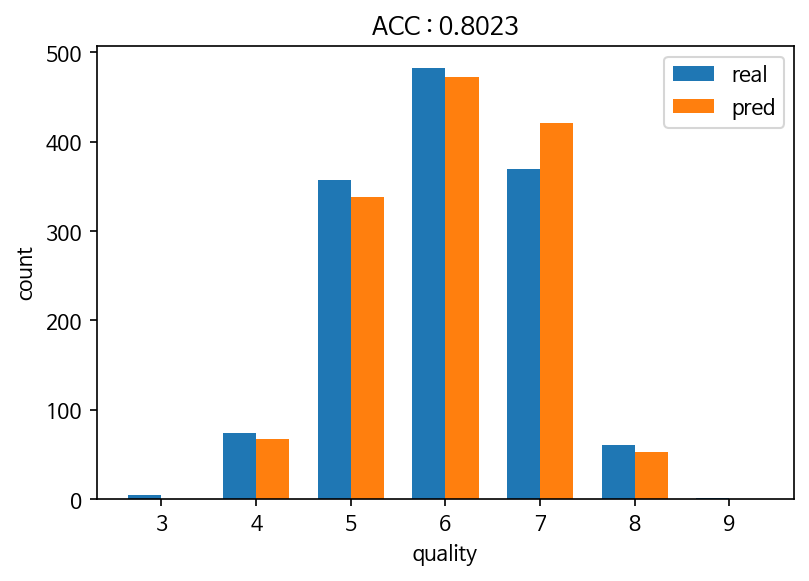

In [ ]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle = True)
# 추가
models = []
for train_idx, valid_idx in kfold.split(X, y):
  X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
  y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

  model = RandomForestClassifier()

  model.fit(X_train, y_train)

  #추가
  models.append(model)

  y_pred = model.predict(X_valid)

  make_plot()

In [ ]:
test['type'] = test['type'].map(lambda x : 0 if x == 'white' else 1)

In [ ]:
pred0 = models[0].predict(test[features])
pred1 = models[1].predict(test[features])
pred2 = models[2].predict(test[features])
pred3 = models[3].predict(test[features])
pred4 = models[4].predict(test[features])

### 2) 하드 보팅

In [ ]:
pred = pd.DataFrame({'pred0':pred0, 'pred1':pred1, 'pred2':pred2, 'pred3':pred3, 'pred4':pred4})
pred

,pred0,pred1,pred2,pred3,pred4
0,6,5,5,6,5
1,6,6,6,5,5
2,6,6,6,6,6
3,5,5,5,6,5
4,6,6,7,6,6
...,...,...,...,...,...
995,6,6,6,5,6
996,6,6,6,6,6
997,5,5,5,5,5
998,6,6,6,6,6


In [ ]:
pred['pred'] = pred.mode(axis=1)[0].astype(int)
pred

,pred0,pred1,pred2,pred3,pred4,pred
0,6,5,5,6,5,5
1,6,6,6,5,5,6
2,6,6,6,6,6,6
3,5,5,5,6,5,5
4,6,6,7,6,6,6
...,...,...,...,...,...,...
995,6,6,6,5,6,6
996,6,6,6,6,6,6
997,5,5,5,5,5,5
998,6,6,6,6,6,6


In [ ]:
submission['quality'] = pred.mode(axis=1)[0].astype(int)
submission

,index,quality
0,0,5
1,1,6
2,2,6
3,3,5
4,4,6
...,...,...
995,995,6
996,996,6
997,997,5
998,998,6


In [ ]:
#submission.to_csv('submission.csv', index=False)

# 점수 : 0.689

### 3) 소프트 보팅

In [ ]:
pred0 = models[0].predict_proba(test[features])
pred0

array([[0.01, 0.21, 0.18, ..., 0.11, 0.07, 0.  ],
       [0.02, 0.09, 0.23, ..., 0.01, 0.  , 0.  ],
       [0.01, 0.02, 0.32, ..., 0.05, 0.01, 0.  ],
       ...,
       [0.  , 0.09, 0.57, ..., 0.01, 0.  , 0.  ],
       [0.  , 0.05, 0.13, ..., 0.06, 0.  , 0.  ],
       [0.  , 0.  , 0.02, ..., 0.15, 0.02, 0.  ]])

In [ ]:
pd.DataFrame(pred0)

,0,1,2,3,4,5,6
0,0.01,0.21,0.18,0.42,0.11,0.07,0.00
1,0.02,0.09,0.23,0.65,0.01,0.00,0.00
2,0.01,0.02,0.32,0.59,0.05,0.01,0.00
3,0.00,0.07,0.76,0.15,0.02,0.00,0.00
4,0.00,0.03,0.01,0.52,0.40,0.02,0.02
...,...,...,...,...,...,...,...
995,0.00,0.00,0.33,0.66,0.01,0.00,0.00
996,0.00,0.07,0.36,0.42,0.12,0.03,0.00
997,0.00,0.09,0.57,0.33,0.01,0.00,0.00
998,0.00,0.05,0.13,0.76,0.06,0.00,0.00


In [ ]:
pred0 = models[0].predict_proba(test[features])
pred1 = models[1].predict_proba(test[features])
pred2 = models[2].predict_proba(test[features])
pred3 = models[3].predict_proba(test[features])
pred4 = models[4].predict_proba(test[features])

In [ ]:
pred = pd.DataFrame((pred0 + pred1 + pred2 + pred3 + pred4)/5)
pred

,0,1,2,3,4,5,6
0,0.004,0.152,0.308,0.328,0.156,0.050,0.002
1,0.020,0.120,0.366,0.478,0.016,0.000,0.000
2,0.006,0.046,0.328,0.572,0.036,0.012,0.000
3,0.002,0.030,0.626,0.256,0.084,0.002,0.000
4,0.000,0.034,0.044,0.478,0.396,0.040,0.008
...,...,...,...,...,...,...,...
995,0.000,0.010,0.428,0.558,0.004,0.000,0.000
996,0.002,0.068,0.256,0.482,0.166,0.026,0.000
997,0.006,0.072,0.572,0.314,0.036,0.000,0.000
998,0.000,0.068,0.176,0.696,0.054,0.006,0.000


In [ ]:
pd.DataFrame(np.argmax(np.array(pred), axis=1))

,0
0,3
1,3
2,3
3,2
4,3
...,...
995,3
996,3
997,2
998,3


In [ ]:
pred['quality'] = np.argmax(np.array(pred), axis=1)
pred

,0,1,2,3,4,5,6,quality
0,0.004,0.152,0.308,0.328,0.156,0.050,0.002,3
1,0.020,0.120,0.366,0.478,0.016,0.000,0.000,3
2,0.006,0.046,0.328,0.572,0.036,0.012,0.000,3
3,0.002,0.030,0.626,0.256,0.084,0.002,0.000,2
4,0.000,0.034,0.044,0.478,0.396,0.040,0.008,3
...,...,...,...,...,...,...,...,...
995,0.000,0.010,0.428,0.558,0.004,0.000,0.000,3
996,0.002,0.068,0.256,0.482,0.166,0.026,0.000,3
997,0.006,0.072,0.572,0.314,0.036,0.000,0.000,2
998,0.000,0.068,0.176,0.696,0.054,0.006,0.000,3


In [ ]:
pred['quality'] = pred['quality'] + 3
pred

,0,1,2,3,4,5,6,quality
0,0.004,0.152,0.308,0.328,0.156,0.050,0.002,6
1,0.020,0.120,0.366,0.478,0.016,0.000,0.000,6
2,0.006,0.046,0.328,0.572,0.036,0.012,0.000,6
3,0.002,0.030,0.626,0.256,0.084,0.002,0.000,5
4,0.000,0.034,0.044,0.478,0.396,0.040,0.008,6
...,...,...,...,...,...,...,...,...
995,0.000,0.010,0.428,0.558,0.004,0.000,0.000,6
996,0.002,0.068,0.256,0.482,0.166,0.026,0.000,6
997,0.006,0.072,0.572,0.314,0.036,0.000,0.000,5
998,0.000,0.068,0.176,0.696,0.054,0.006,0.000,6


## 1.EDA-features

In [ ]:
X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,0
1,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,1
2,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,0
3,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,0
4,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5481,5.4,0.835,0.08,1.2,0.046,13.0,93.0,0.99240,3.57,0.85,13.0,1
5482,6.2,0.430,0.49,6.4,0.045,12.0,115.0,0.99630,3.27,0.57,9.0,0
5485,6.3,0.280,0.22,9.5,0.040,30.0,111.0,0.99338,3.05,0.31,10.8,0
5491,6.9,0.340,0.30,4.7,0.029,34.0,148.0,0.99165,3.36,0.49,12.3,0


In [ ]:
def make_plots(text:str):
  plt.title(text + ' vs quality')

  x = train.groupby('quality').mean().reset_index()['quality']
  y = train.groupby('quality').mean().reset_index()[text]

  plt.bar(x,y)
  plt.show()

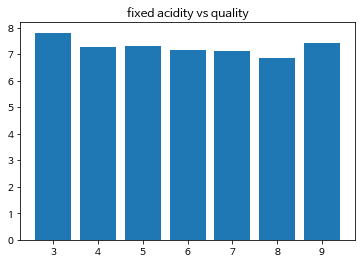

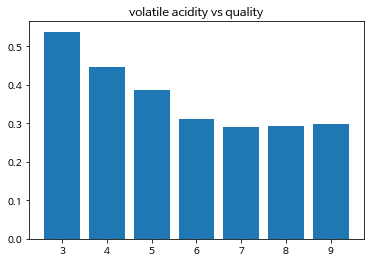

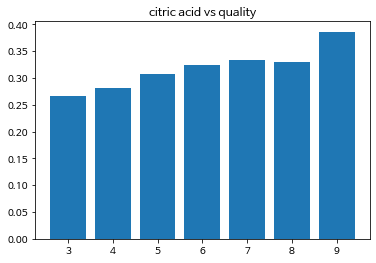

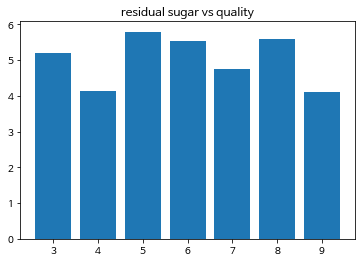

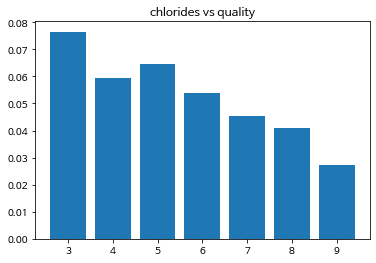

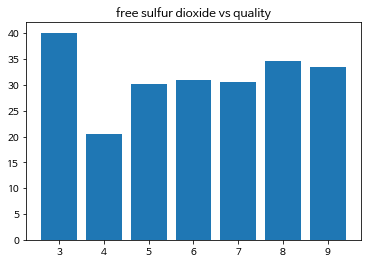

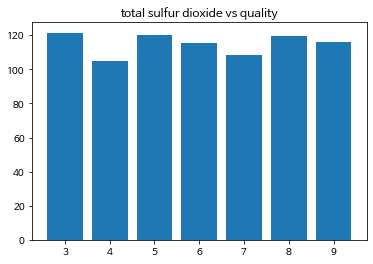

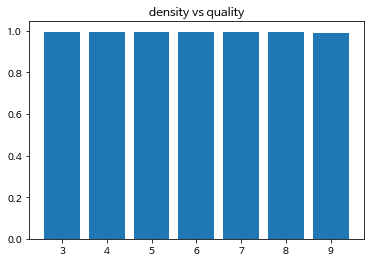

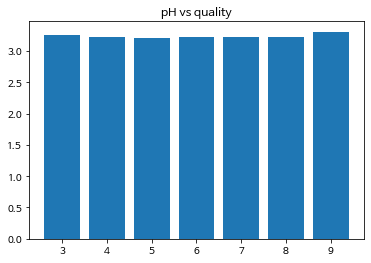

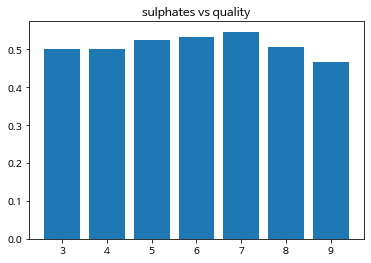

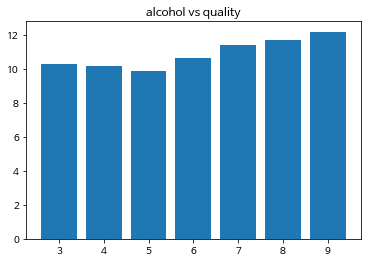

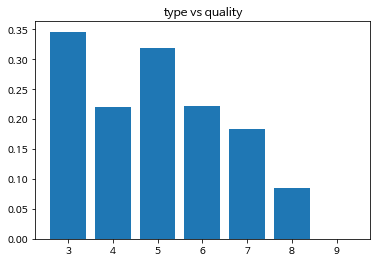

In [ ]:
for col in train.groupby('quality').mean().reset_index().columns[2:]:
  make_plots(col)

## 2.데이터 전처리 기법

### 1) one-hot encoding

In [ ]:
train

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,0
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,1
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,0
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,0
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5481,5481,7,5.4,0.835,0.08,1.2,0.046,13.0,93.0,0.99240,3.57,0.85,13.0,1
5482,5482,4,6.2,0.430,0.49,6.4,0.045,12.0,115.0,0.99630,3.27,0.57,9.0,0
5485,5485,4,6.3,0.280,0.22,9.5,0.040,30.0,111.0,0.99338,3.05,0.31,10.8,0
5491,5491,7,6.9,0.340,0.30,4.7,0.029,34.0,148.0,0.99165,3.36,0.49,12.3,0


In [ ]:
train['type'] = train['type'].map(lambda x : 'white' if x == 0 else 'red')

In [ ]:
train

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5481,5481,7,5.4,0.835,0.08,1.2,0.046,13.0,93.0,0.99240,3.57,0.85,13.0,red
5482,5482,4,6.2,0.430,0.49,6.4,0.045,12.0,115.0,0.99630,3.27,0.57,9.0,white
5485,5485,4,6.3,0.280,0.22,9.5,0.040,30.0,111.0,0.99338,3.05,0.31,10.8,white
5491,5491,7,6.9,0.340,0.30,4.7,0.029,34.0,148.0,0.99165,3.36,0.49,12.3,white


In [ ]:
train = pd.concat([train,pd.get_dummies(train['type'])], axis=1)
train

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,red,white
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white,0,1
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red,1,0
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white,0,1
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white,0,1
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5481,5481,7,5.4,0.835,0.08,1.2,0.046,13.0,93.0,0.99240,3.57,0.85,13.0,red,1,0
5482,5482,4,6.2,0.430,0.49,6.4,0.045,12.0,115.0,0.99630,3.27,0.57,9.0,white,0,1
5485,5485,4,6.3,0.280,0.22,9.5,0.040,30.0,111.0,0.99338,3.05,0.31,10.8,white,0,1
5491,5491,7,6.9,0.340,0.30,4.7,0.029,34.0,148.0,0.99165,3.36,0.49,12.3,white,0,1


In [ ]:
train.columns[2:13]

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

### ad 피처추가 - 실패

In [ ]:
#train['ad'] = train['density'] / train['alcohol']

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


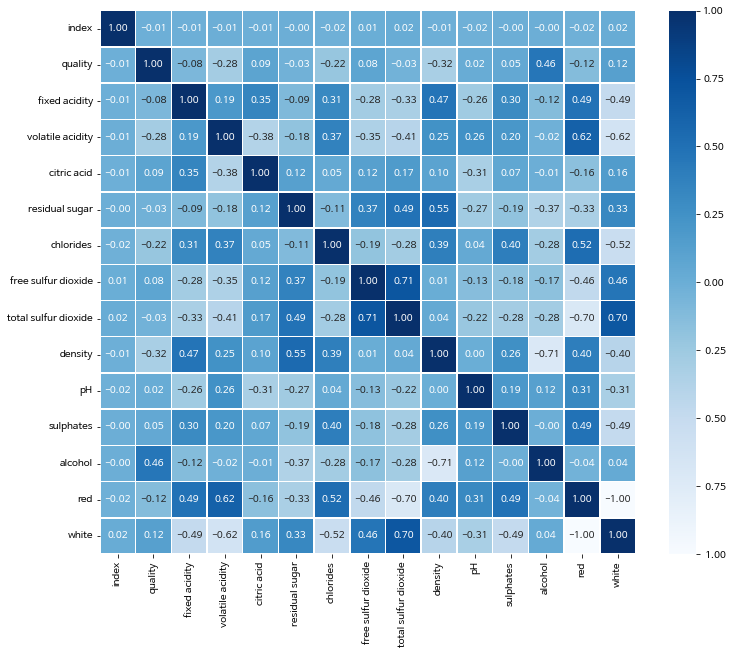

In [ ]:
import seaborn as sns 

plt.figure(figsize=(12,10))
sns.heatmap(data = train.corr(method='pearson'), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

In [ ]:
from scipy import stats
import numpy as np

# sns.distplot(train['ad'], fit=stats.norm)

In [ ]:
# x = train.groupby('quality').mean().reset_index()['quality']
# y = train.groupby('quality').mean().reset_index()['ad']

# plt.bar(x,y)
# plt.show()

### 총 이산화황 - 독립 이산화황 -> 실패

In [ ]:
#train['tf'] = train['total sulfur dioxide'] - train['free sulfur dioxide']

In [ ]:
#sns.distplot(train['tf'], fit=stats.norm)

In [ ]:
# x = train.groupby('quality').mean().reset_index()['quality']
# y = train.groupby('quality').mean().reset_index()['tf']

# plt.bar(x,y)
# plt.show()

### 산도와 ph - 실패

pH가 작을수록 산도가 높다.

실패이유는 상관관계가 안좋아서이지 않을까 싶다.

In [ ]:
train.head(1)

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,red,white
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white,0,1


In [ ]:
#train['fph'] = train['fixed acidity'] / train['pH']

In [ ]:
#sns.distplot(train['fph'], fit=stats.norm)

In [ ]:
# x = train.groupby('quality').mean().reset_index()['quality']
# y = train.groupby('quality').mean().reset_index()['fph']

# plt.bar(x,y)
# plt.show()

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6759 entries, 0 to 5494
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 6759 non-null   int64  
 1   quality               6759 non-null   int64  
 2   fixed acidity         6759 non-null   float64
 3   volatile acidity      6759 non-null   float64
 4   citric acid           6759 non-null   float64
 5   residual sugar        6759 non-null   float64
 6   chlorides             6759 non-null   float64
 7   free sulfur dioxide   6759 non-null   float64
 8   total sulfur dioxide  6759 non-null   float64
 9   density               6759 non-null   float64
 10  pH                    6759 non-null   float64
 11  sulphates             6759 non-null   float64
 12  alcohol               6759 non-null   float64
 13  type                  6759 non-null   object 
 14  red                   6759 non-null   uint8  
 15  white                

In [ ]:
train

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,red,white
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white,0,1
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red,1,0
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white,0,1
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white,0,1
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5481,5481,7,5.4,0.835,0.08,1.2,0.046,13.0,93.0,0.99240,3.57,0.85,13.0,red,1,0
5482,5482,4,6.2,0.430,0.49,6.4,0.045,12.0,115.0,0.99630,3.27,0.57,9.0,white,0,1
5485,5485,4,6.3,0.280,0.22,9.5,0.040,30.0,111.0,0.99338,3.05,0.31,10.8,white,0,1
5491,5491,7,6.9,0.340,0.30,4.7,0.029,34.0,148.0,0.99165,3.36,0.49,12.3,white,0,1


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


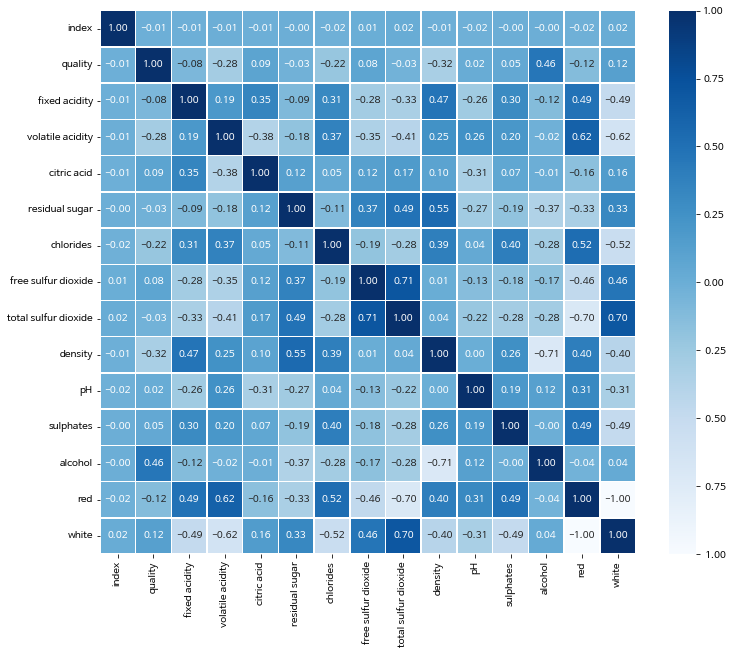

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(data = train.corr(method='pearson'), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

### 2) 스케일링

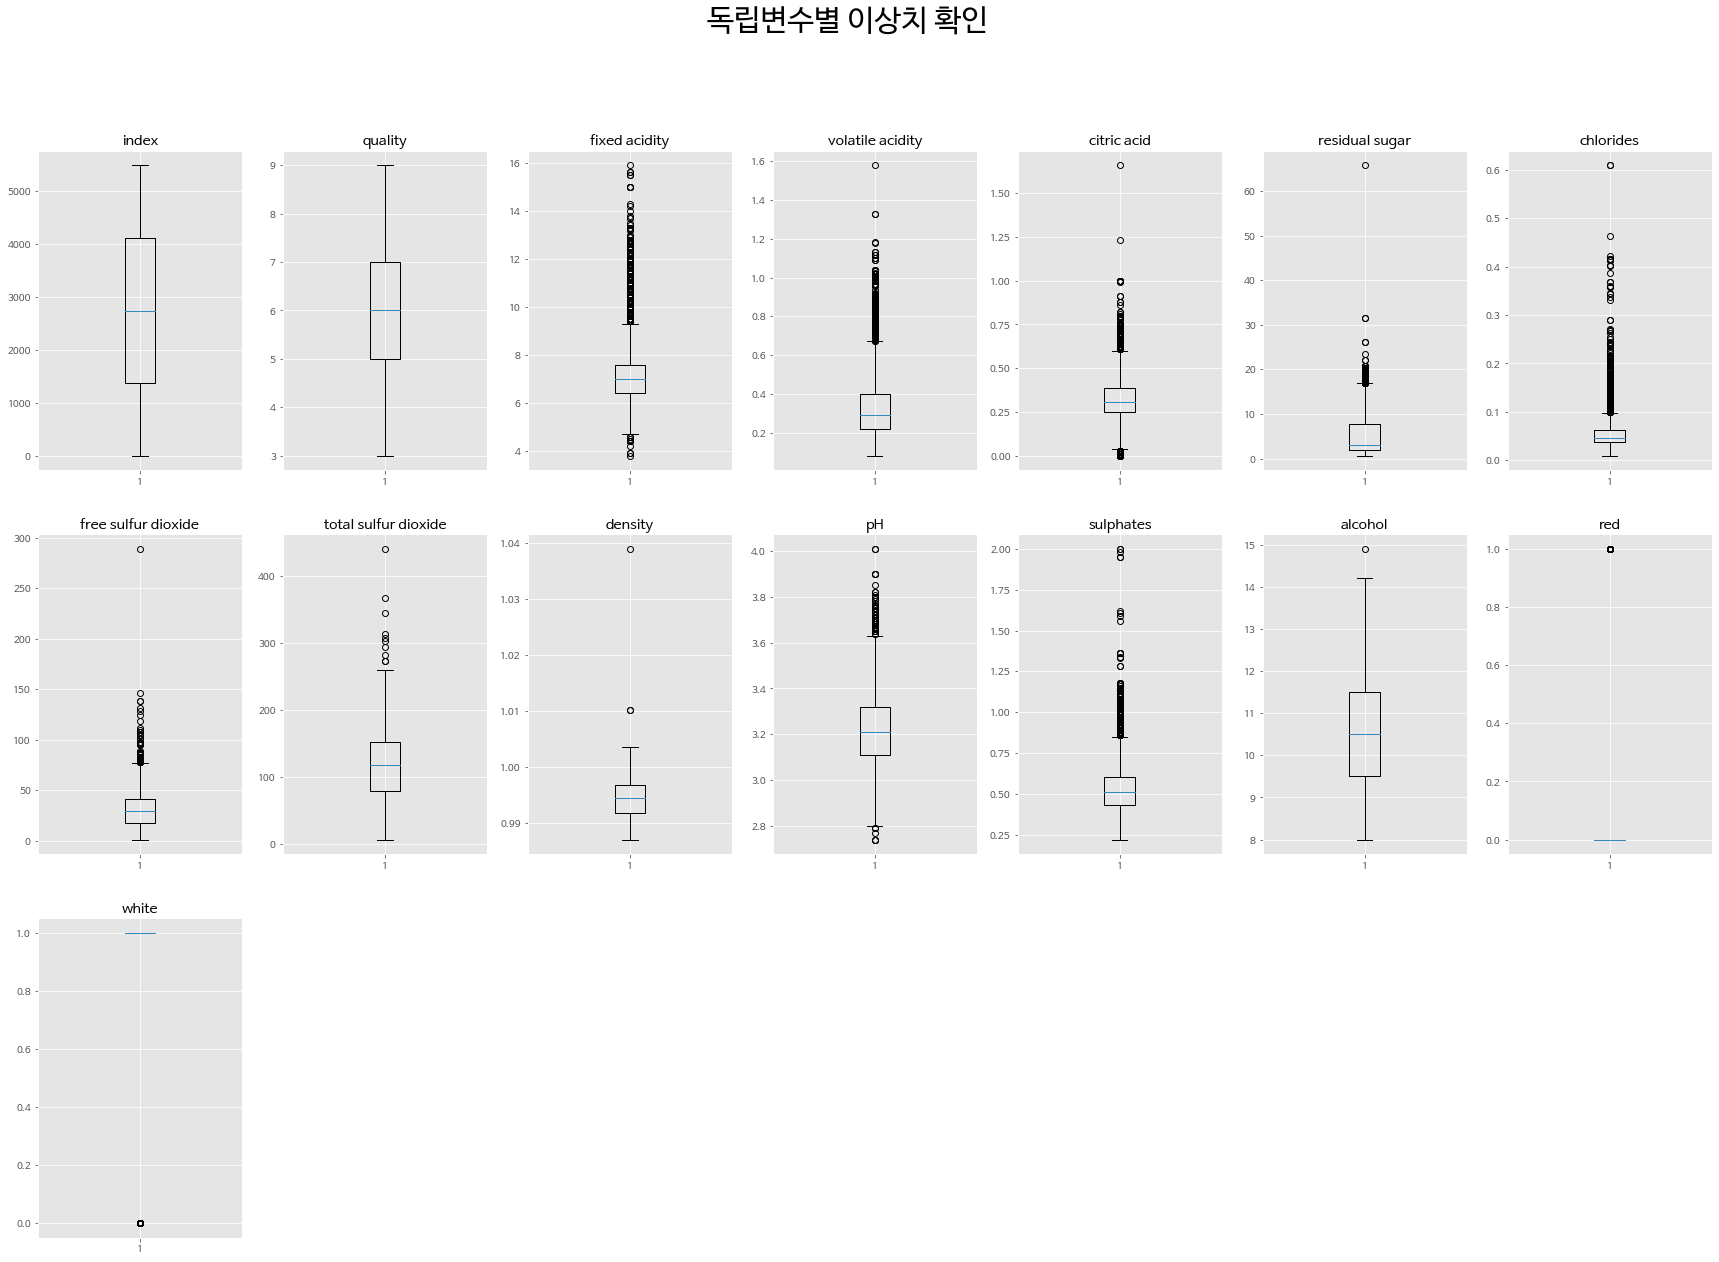

In [ ]:
plt.style.use('ggplot')

feature = train.describe().columns

plt.figure(figsize = (30,20))
plt.suptitle('독립변수별 이상치 확인',fontsize=30)

for i in range(len(feature)):
  plt.subplot(3,7,i+1)
  plt.title(feature[i])
  plt.boxplot(train[feature[i]])

plt.show()

#### RobustScaler를 사용해서 해보면? - 실패

In [ ]:
train.describe()

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red,white
count,6759.000000,6759.000000,6759.000000,6759.000000,6759.000000,6759.000000,6759.000000,6759.000000,6759.000000,6759.000000,6759.000000,6759.000000,6759.000000,6759.000000,6759.000000
mean,2746.557775,5.979435,7.191648,0.333522,0.319729,5.311518,0.054143,30.245377,114.347241,0.994415,3.220897,0.531373,10.642592,0.230951,0.769049
std,1583.595529,0.989449,1.293819,0.161188,0.141271,4.637002,0.033676,17.390089,55.053052,0.003056,0.161207,0.152189,1.242245,0.421473,0.421473
min,0.000000,3.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.740000,0.220000,8.000000,0.000000,0.000000
25%,1378.500000,5.000000,6.400000,0.220000,0.250000,1.800000,0.037000,17.000000,79.000000,0.991920,3.110000,0.430000,9.500000,0.000000,1.000000
50%,2747.000000,6.000000,7.000000,0.290000,0.310000,3.000000,0.046000,29.000000,117.000000,0.994440,3.210000,0.510000,10.500000,0.000000,1.000000
75%,4112.500000,7.000000,7.600000,0.400000,0.390000,7.825000,0.061500,41.000000,152.000000,0.996800,3.320000,0.600000,11.500000,0.000000,1.000000
max,5496.000000,9.000000,15.900000,1.580000,1.660000,65.800000,0.610000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,1.000000,1.000000


In [ ]:
# a=['fixed acidity',	'volatile acidity',	'citric acid',	'residual sugar',	'chlorides',	'free sulfur dioxide', 'sulphates']

# b=['total sulfur dioxide',	'density',	'pH']

In [ ]:
# from sklearn.preprocessing import RobustScaler

# scaler1 = RobustScaler()

# train[a] = scaler1.fit_transform(train[a])
# train

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# scaler2 = MinMaxScaler()

# train[b] = scaler2.fit_transform(train[b])
# train

In [ ]:
train.columns[2:13]

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [ ]:
train.columns[-3:]

Index(['type', 'red', 'white'], dtype='object')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

s=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates']

#train[train.columns[2:13]] = scaler.fit_transform(train[train.columns[2:13]])
train[s] = scaler.fit_transform(train[s])
train

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,red,white
0,0,5,0.148760,0.410000,0.036145,0.095092,0.054908,0.027778,0.179724,0.139001,0.551181,0.123596,10.2,white,0,1
1,1,5,0.413223,0.353333,0.084337,0.027607,0.096506,0.031250,0.082949,0.188741,0.354331,0.207865,9.5,red,1,0
2,2,5,0.338843,0.086667,0.234940,0.021472,0.079867,0.069444,0.304147,0.089647,0.244094,0.168539,10.9,white,0,1
3,3,6,0.264463,0.086667,0.186747,0.082822,0.061564,0.097222,0.235023,0.130904,0.409449,0.157303,10.8,white,0,1
4,4,6,0.330579,0.213333,0.156627,0.136503,0.083195,0.107639,0.396313,0.161751,0.236220,0.117978,10.9,white,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5481,5481,7,0.132231,0.503333,0.048193,0.009202,0.061564,0.041667,0.200461,0.101986,0.653543,0.353933,13.0,red,1,0
5482,5482,4,0.198347,0.233333,0.295181,0.088957,0.059900,0.038194,0.251152,0.177174,0.417323,0.196629,9.0,white,0,1
5485,5485,4,0.206612,0.133333,0.132530,0.136503,0.051581,0.100694,0.241935,0.120879,0.244094,0.050562,10.8,white,0,1
5491,5491,7,0.256198,0.173333,0.180723,0.062883,0.033278,0.114583,0.327189,0.087527,0.488189,0.151685,12.3,white,0,1


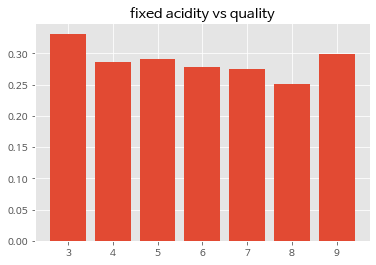

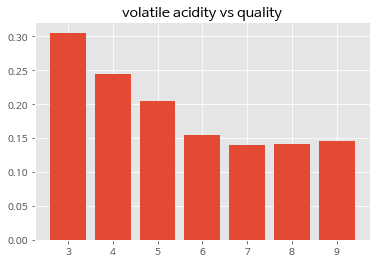

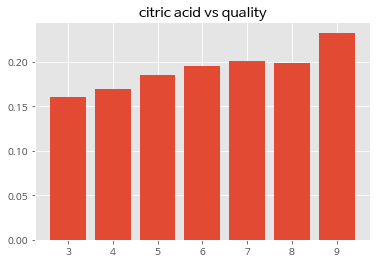

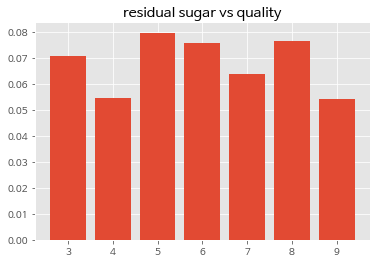

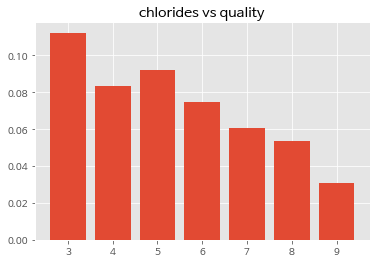

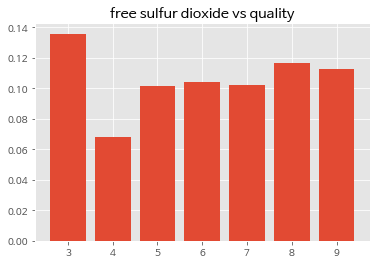

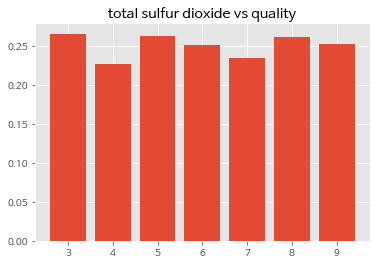

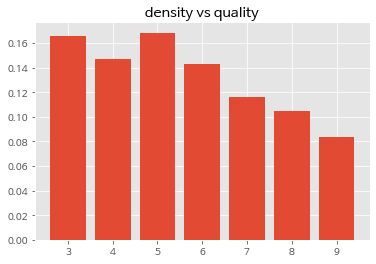

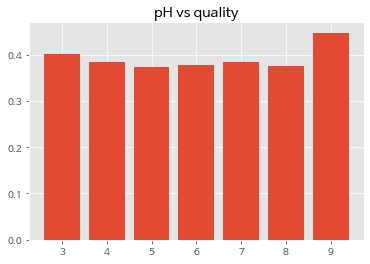

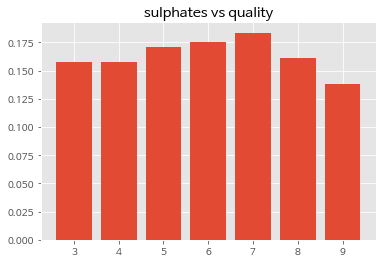

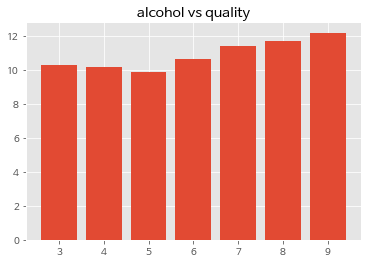

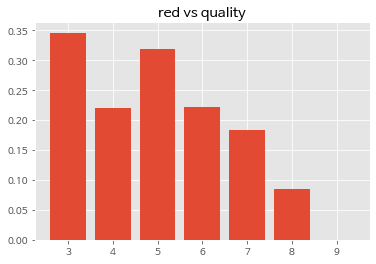

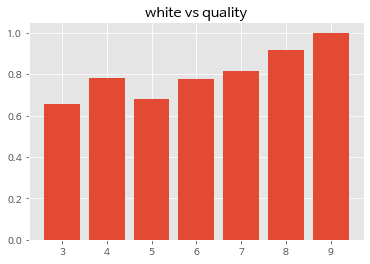

In [ ]:
for col in train.groupby('quality').mean().reset_index().columns[2:]:
  make_plots(col)

In [ ]:
train

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,red,white
0,0,5,0.148760,0.410000,0.036145,0.095092,0.054908,0.027778,0.179724,0.139001,0.551181,0.123596,10.2,white,0,1
1,1,5,0.413223,0.353333,0.084337,0.027607,0.096506,0.031250,0.082949,0.188741,0.354331,0.207865,9.5,red,1,0
2,2,5,0.338843,0.086667,0.234940,0.021472,0.079867,0.069444,0.304147,0.089647,0.244094,0.168539,10.9,white,0,1
3,3,6,0.264463,0.086667,0.186747,0.082822,0.061564,0.097222,0.235023,0.130904,0.409449,0.157303,10.8,white,0,1
4,4,6,0.330579,0.213333,0.156627,0.136503,0.083195,0.107639,0.396313,0.161751,0.236220,0.117978,10.9,white,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5481,5481,7,0.132231,0.503333,0.048193,0.009202,0.061564,0.041667,0.200461,0.101986,0.653543,0.353933,13.0,red,1,0
5482,5482,4,0.198347,0.233333,0.295181,0.088957,0.059900,0.038194,0.251152,0.177174,0.417323,0.196629,9.0,white,0,1
5485,5485,4,0.206612,0.133333,0.132530,0.136503,0.051581,0.100694,0.241935,0.120879,0.244094,0.050562,10.8,white,0,1
5491,5491,7,0.256198,0.173333,0.180723,0.062883,0.033278,0.114583,0.327189,0.087527,0.488189,0.151685,12.3,white,0,1


#### ph 드랍하기 - 변화x

In [ ]:
train.columns[2:]

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'type', 'red', 'white'],
      dtype='object')

In [ ]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol', 'red', 'white']
features

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'red',
 'white']

In [ ]:
X = train[features]
y = train['quality']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6759 entries, 0 to 5494
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6759 non-null   float64
 1   volatile acidity      6759 non-null   float64
 2   citric acid           6759 non-null   float64
 3   residual sugar        6759 non-null   float64
 4   chlorides             6759 non-null   float64
 5   free sulfur dioxide   6759 non-null   float64
 6   total sulfur dioxide  6759 non-null   float64
 7   density               6759 non-null   float64
 8   pH                    6759 non-null   float64
 9   sulphates             6759 non-null   float64
 10  alcohol               6759 non-null   float64
 11  red                   6759 non-null   uint8  
 12  white                 6759 non-null   uint8  
dtypes: float64(11), uint8(2)
memory usage: 646.9 KB


### 3) 성능 검증

- 랜덤포레스트는 성능이 떨어짐

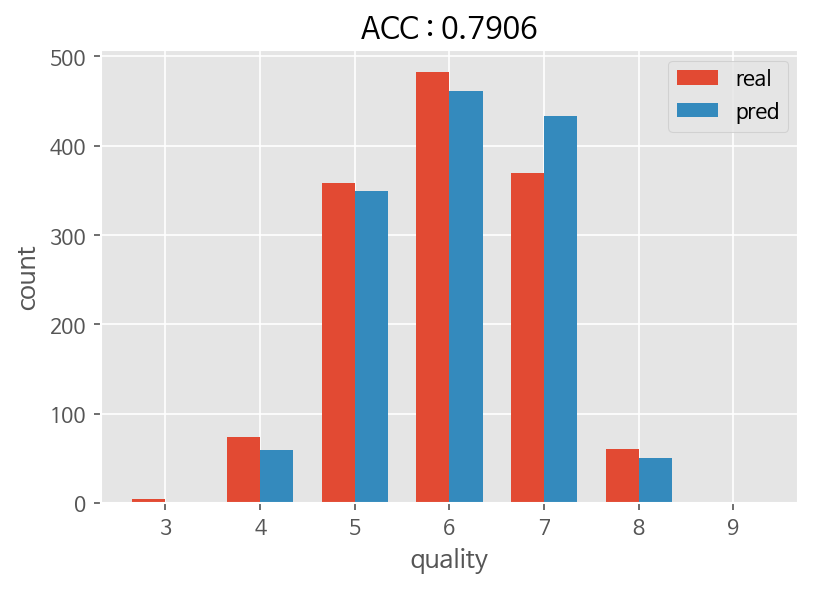

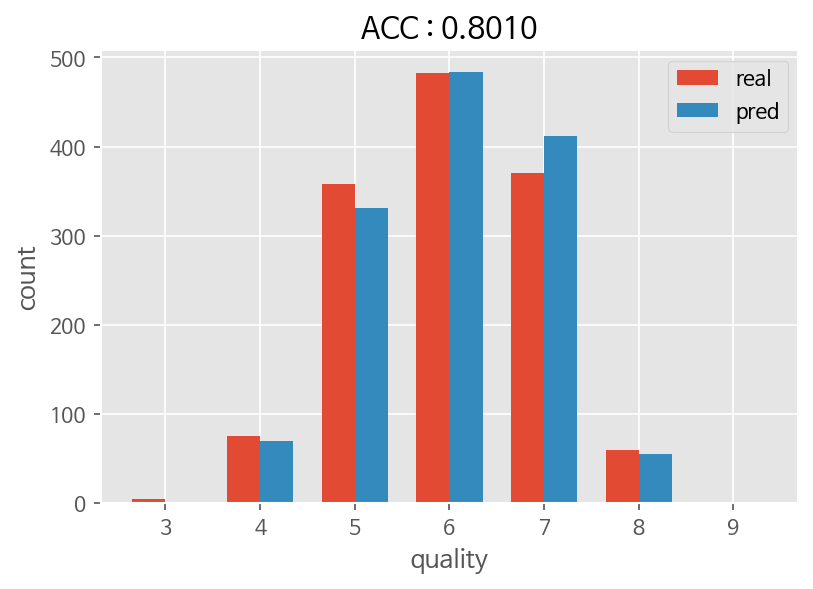

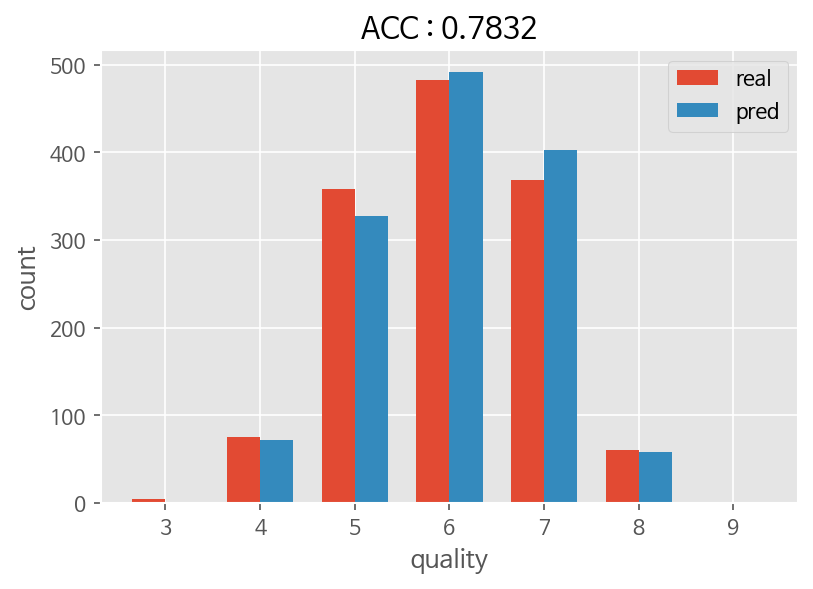

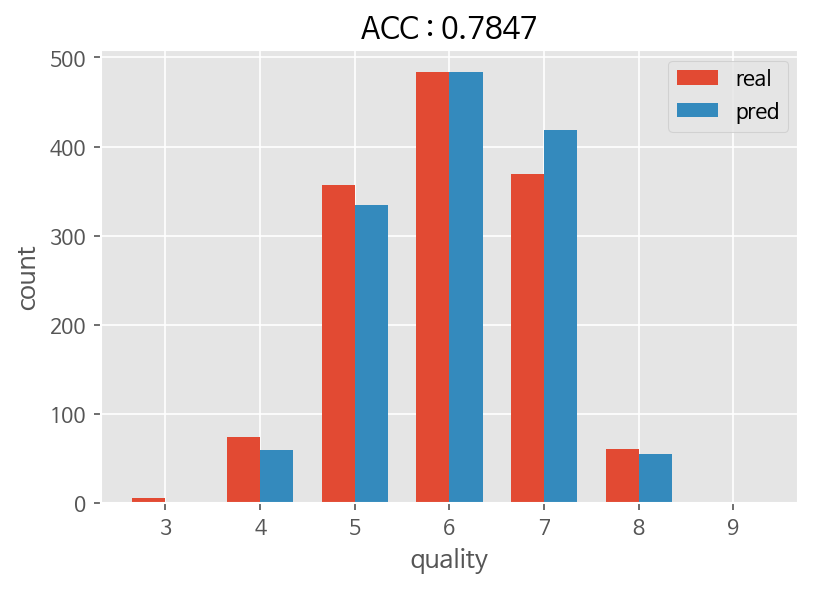

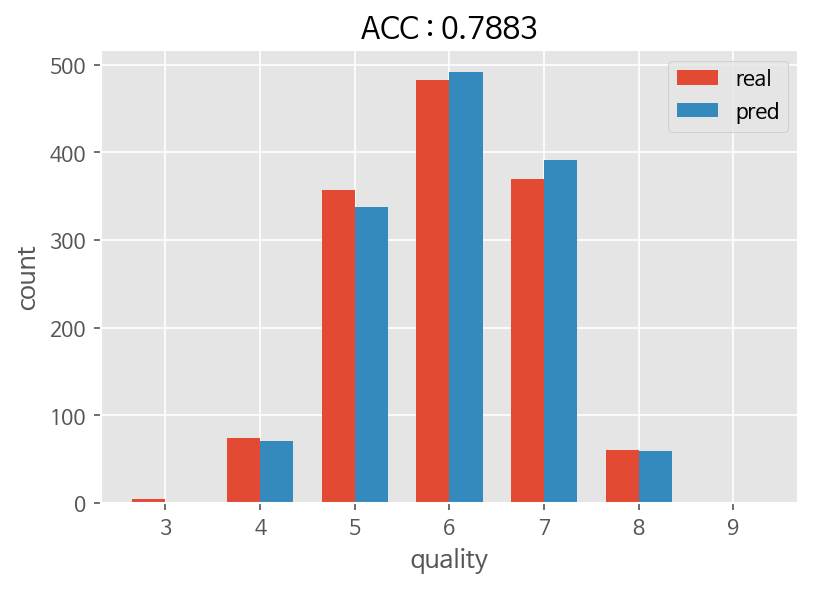

In [ ]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle = True)
# 추가
models = []
for train_idx, valid_idx in kfold.split(X, y):
  X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
  y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

  model = RandomForestClassifier()

  model.fit(X_train, y_train)

  #추가
  models.append(model)

  y_pred = model.predict(X_valid)

  make_plot()

## 3.GridSearchCV

### 1) GridSearchCV로 교차검증과 하이퍼파라미터 튜닝하기

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {'n_estimators' : [100, 150, 200],
          'criterion' : ['gini', 'entropy']}

rf = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5, return_train_score=True, verbose=2)

rf.fit(X_train,y_train)

y_pred = rf.predict(X_valid)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


[CV] END ...................criterion=gini, n_estimators=100; total time=   0.9s
[CV] END ...................criterion=gini, n_estimators=100; total time=   0.9s
[CV] END ...................criterion=gini, n_estimators=100; total time=   0.9s
[CV] END ...................criterion=gini, n_estimators=100; total time=   1.0s
[CV] END ...................criterion=gini, n_estimators=100; total time=   0.9s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.4s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.4s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.4s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.4s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.4s
[CV] END ...................criterion=gini, n_estimators=200; total time=   1.9s
[CV] END ...................criterion=gini, n_estimators=200; total time=   1.9s
[CV] END ...................

### 2) validation 셋으로 검증하기

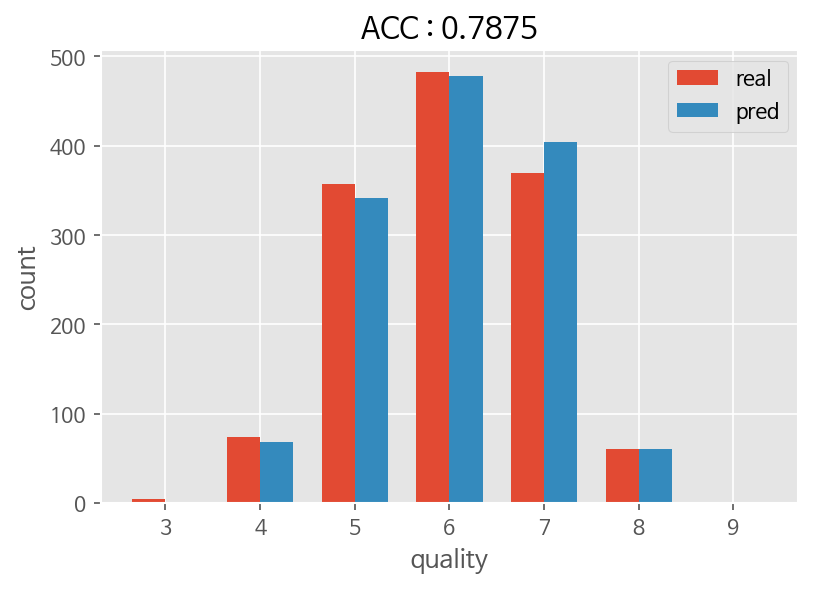

In [ ]:
make_plot()

In [ ]:
rf.best_score_

0.7745932516103218

In [ ]:
rf.best_params_

{'criterion': 'entropy', 'n_estimators': 200}

### 3) validation 셋 구축 X

In [ ]:
params = {'n_estimators' : [100, 150, 200],
          'criterion' : ['gini', 'entropy']}

rf = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5, return_train_score=True, verbose=2)

rf.fit(X,y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...................criterion=gini, n_estimators=100; total time=   1.2s
[CV] END ...................criterion=gini, n_estimators=100; total time=   1.1s
[CV] END ...................criterion=gini, n_estimators=100; total time=   1.1s
[CV] END ...................criterion=gini, n_estimators=100; total time=   1.1s
[CV] END ...................criterion=gini, n_estimators=100; total time=   1.1s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.7s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.7s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.7s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.7s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.7s
[CV] END ...................criterion=gini, n_estimators=200; total time=   2.2s
[CV] END ...................criterion=gini, n_est

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [100, 150, 200]},
             return_train_score=True, verbose=2)

In [ ]:
rf.best_score_

0.8226049956420622

In [ ]:
rf.best_params_

{'criterion': 'gini', 'n_estimators': 200}

## 4.모델 앙상블

### 1) GridSearchCV로 모델 학습

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
models = []

rfc = RandomForestClassifier( ) 

models.append(rfc)

gbc = GradientBoostingClassifier( )

models.append(gbc)

etc = ExtraTreesClassifier()

models.append(etc)

파라미터 설정을 안해준거 또는 밑과 같이 해준 결과 중 하나가 최종 프라이빗 점수일것이다. (두개 제출 중 무엇이 프라이빗인지 확인 불가)

In [ ]:
best_models={}
best_params={}
score={}
params = [{'n_estimators' : [100, 150, 200],'criterion' : ['gini']},{'n_estimators' : [150,200],"max_depth": [10,12],"learning_rate" : [0.1]},{}]

for i, model in enumerate(models):
  model = GridSearchCV(model, param_grid=params[i], cv=5, return_train_score=True, verbose=2)
  
  model.fit(X,y)

  best_models[i] = model.best_estimator_
  best_params[i] = model.best_params_
  score[i] = model.best_score_

  # best_models.append(model)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ...................criterion=gini, n_estimators=100; total time=   1.2s
[CV] END ...................criterion=gini, n_estimators=100; total time=   1.1s
[CV] END ...................criterion=gini, n_estimators=100; total time=   1.1s
[CV] END ...................criterion=gini, n_estimators=100; total time=   1.1s
[CV] END ...................criterion=gini, n_estimators=100; total time=   1.1s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.7s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.7s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.7s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.7s
[CV] END ...................criterion=gini, n_estimators=150; total time=   1.6s
[CV] END ...................criterion=gini, n_estimators=200; total time=   2.2s
[CV] END ...................criterion=gini, n_est

### 2) fold별 best_model을 이용해서 커스텀 보팅하기

In [ ]:
best_models

{0: RandomForestClassifier(),
 1: GradientBoostingClassifier(max_depth=12, n_estimators=200),
 2: ExtraTreesClassifier()}

In [ ]:
best_params

{0: {'criterion': 'gini', 'n_estimators': 100},
 1: {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 200},
 2: {}}

In [ ]:
score

{0: 0.8194982677744734, 1: 0.8304474222469441, 2: 0.8348857300531274}

### test셋 구축

In [ ]:
test

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,9.0,0.31,0.48,6.60,0.043,11.0,73.0,0.99380,2.90,0.38,11.6,0
1,1,13.3,0.43,0.58,1.90,0.070,15.0,40.0,1.00040,3.06,0.49,9.0,1
2,2,6.5,0.28,0.27,5.20,0.040,44.0,179.0,0.99480,3.19,0.69,9.4,0
3,3,7.2,0.15,0.39,1.80,0.043,21.0,159.0,0.99480,3.52,0.47,10.0,0
4,4,6.8,0.26,0.26,2.00,0.019,23.5,72.0,0.99041,3.16,0.47,11.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,7.1,0.59,0.02,2.30,0.082,24.0,94.0,0.99744,3.55,0.53,9.7,1
996,996,8.7,0.15,0.30,1.60,0.046,29.0,130.0,0.99420,3.22,0.38,9.8,0
997,997,8.8,0.66,0.26,1.70,0.074,4.0,23.0,0.99710,3.15,0.74,9.2,1
998,998,7.0,0.42,0.19,2.30,0.071,18.0,36.0,0.99476,3.39,0.56,10.9,1


In [ ]:
test['type'] = test['type'].map(lambda x : 'white' if x == 0 else 'red')

In [ ]:
test = pd.concat([test,pd.get_dummies(test['type'])], axis=1)
test

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,red,white
0,0,9.0,0.31,0.48,6.60,0.043,11.0,73.0,0.99380,2.90,0.38,11.6,white,0,1
1,1,13.3,0.43,0.58,1.90,0.070,15.0,40.0,1.00040,3.06,0.49,9.0,red,1,0
2,2,6.5,0.28,0.27,5.20,0.040,44.0,179.0,0.99480,3.19,0.69,9.4,white,0,1
3,3,7.2,0.15,0.39,1.80,0.043,21.0,159.0,0.99480,3.52,0.47,10.0,white,0,1
4,4,6.8,0.26,0.26,2.00,0.019,23.5,72.0,0.99041,3.16,0.47,11.8,white,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,7.1,0.59,0.02,2.30,0.082,24.0,94.0,0.99744,3.55,0.53,9.7,red,1,0
996,996,8.7,0.15,0.30,1.60,0.046,29.0,130.0,0.99420,3.22,0.38,9.8,white,0,1
997,997,8.8,0.66,0.26,1.70,0.074,4.0,23.0,0.99710,3.15,0.74,9.2,red,1,0
998,998,7.0,0.42,0.19,2.30,0.071,18.0,36.0,0.99476,3.39,0.56,10.9,red,1,0


In [ ]:
test.columns[1:12]

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [ ]:
# test[a] = scaler1.fit_transform(test[a])
# test[b] = scaler2.fit_transform(test[b])
# test

In [ ]:
#test['ad'] = test['density'] / test['alcohol']

In [ ]:
#test['tf'] = test['total sulfur dioxide'] - test['free sulfur dioxide']

In [ ]:
#test['fph'] = test['fixed acidity'] / test['pH']

In [ ]:
test.columns[-3:]

Index(['type', 'red', 'white'], dtype='object')

In [ ]:
test

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,red,white
0,0,9.0,0.31,0.48,6.60,0.043,11.0,73.0,0.99380,2.90,0.38,11.6,white,0,1
1,1,13.3,0.43,0.58,1.90,0.070,15.0,40.0,1.00040,3.06,0.49,9.0,red,1,0
2,2,6.5,0.28,0.27,5.20,0.040,44.0,179.0,0.99480,3.19,0.69,9.4,white,0,1
3,3,7.2,0.15,0.39,1.80,0.043,21.0,159.0,0.99480,3.52,0.47,10.0,white,0,1
4,4,6.8,0.26,0.26,2.00,0.019,23.5,72.0,0.99041,3.16,0.47,11.8,white,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,7.1,0.59,0.02,2.30,0.082,24.0,94.0,0.99744,3.55,0.53,9.7,red,1,0
996,996,8.7,0.15,0.30,1.60,0.046,29.0,130.0,0.99420,3.22,0.38,9.8,white,0,1
997,997,8.8,0.66,0.26,1.70,0.074,4.0,23.0,0.99710,3.15,0.74,9.2,red,1,0
998,998,7.0,0.42,0.19,2.30,0.071,18.0,36.0,0.99476,3.39,0.56,10.9,red,1,0


In [ ]:
#test[test.columns[1:12]] = scaler.transform(test[test.columns[1:12]])


In [ ]:
test[s] = scaler.transform(test[s])

#### 확률

In [ ]:
features

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'red',
 'white']

In [ ]:
pred0 = best_models[0].predict_proba(test[features])
pred1 = best_models[1].predict_proba(test[features])
pred2 = best_models[2].predict_proba(test[features])

In [ ]:
pred = pd.DataFrame((pred0 + pred1 + pred2)/3)
pred

,0,1,2,3,4,5,6
0,4.275198e-07,9.132160e-02,0.496622,0.287832,0.084218,4.000520e-02,1.604279e-10
1,2.333338e-02,6.676081e-02,0.376304,0.520266,0.013336,1.349207e-07,2.238708e-11
2,3.333336e-03,3.000002e-02,0.254028,0.692638,0.020000,9.637808e-09,1.488178e-12
3,4.868394e-12,3.333333e-03,0.900000,0.090000,0.006667,1.908042e-11,2.976740e-15
4,7.826919e-09,1.666670e-02,0.066670,0.672697,0.213966,2.000003e-02,1.000000e-02
...,...,...,...,...,...,...,...
995,3.565702e-10,1.988523e-09,0.106667,0.886666,0.006667,1.306657e-09,2.175491e-13
996,8.340778e-08,3.000127e-02,0.333822,0.556167,0.070010,1.000032e-02,5.099852e-11
997,8.187459e-10,6.666671e-02,0.689892,0.210108,0.033333,1.481379e-09,2.588726e-13
998,2.028587e-09,3.666668e-02,0.126735,0.796599,0.036667,3.333426e-03,1.202805e-12


In [ ]:
pred['quality'] = pd.DataFrame(np.argmax(np.array(pred), axis=1))
pred['quality'] = pred['quality']+3
pred

,0,1,2,3,4,5,6,quality
0,4.275198e-07,9.132160e-02,0.496622,0.287832,0.084218,4.000520e-02,1.604279e-10,5
1,2.333338e-02,6.676081e-02,0.376304,0.520266,0.013336,1.349207e-07,2.238708e-11,6
2,3.333336e-03,3.000002e-02,0.254028,0.692638,0.020000,9.637808e-09,1.488178e-12,6
3,4.868394e-12,3.333333e-03,0.900000,0.090000,0.006667,1.908042e-11,2.976740e-15,5
4,7.826919e-09,1.666670e-02,0.066670,0.672697,0.213966,2.000003e-02,1.000000e-02,6
...,...,...,...,...,...,...,...,...
995,3.565702e-10,1.988523e-09,0.106667,0.886666,0.006667,1.306657e-09,2.175491e-13,6
996,8.340778e-08,3.000127e-02,0.333822,0.556167,0.070010,1.000032e-02,5.099852e-11,6
997,8.187459e-10,6.666671e-02,0.689892,0.210108,0.033333,1.481379e-09,2.588726e-13,5
998,2.028587e-09,3.666668e-02,0.126735,0.796599,0.036667,3.333426e-03,1.202805e-12,6


In [ ]:
submission['quality']=pred['quality']
submission.to_csv('submission.csv',index=False)